In [160]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [161]:
SOS_token =0
EOS_token=1

In [162]:
class Lang:
    def __init__(self,name):
        self.name=name
        self.word2index={}
        self.word2count={}
        self.index2word={0:'SOS',1:"EOS"}
        self.n_words=2
    
    def addSentence(self,sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.n_words
            self.word2count[word]=1
            self.index2word[self.n_words]=word
            self.n_words +=1
        else:
            self.word2count[word] +=1
        

In [163]:
def normalizeString(s):
    s=s.lower().strip()
    
    s=''.join(
        char for char in unicodedata.normalize('NFD',s)
        if unicodedata.category(char) != 'Mn')
    
    s= re.sub(r"([.!?])",r"",s)
    s= re.sub(r"[^a-zA-Z.!?]+",r" ",s)
        
    return s

In [164]:
def readLangs(lang1,lang2,reverse=False):
    print ("reading")
    lines = open('datasets/data/%s-%s.txt'% (lang1,lang2),encoding="utf-8"). \
    read().strip().split('\n')

    pairs =[[normalizeString(s) for s in l.split('\t')] for l in lines]

    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang=Lang(lang2)
        output_lang=Lang(lang1)
    else:
        input_lang=Lang(lang1)
        output_lang=Lang(lang2)

    return input_lang, output_lang, pairs


In [165]:
MAX_LENGTH = 10

In [166]:
deu_prefixes=("ich habe","ich bin","wir sind","du bist","Sie sind")

In [167]:
def filterPairs(pairs):
    return [p for p in pairs
            if
            len(p[0].split(' ')) < MAX_LENGTH and
            len(p[1].split(' ')) < MAX_LENGTH and
            p[1].startswith(deu_prefixes)]

In [168]:
def prepareData(lang1, lang2, reverse=False):
    input_lang,output_lang, pairs = readLangs(lang1,lang2,reverse)
    print("Read %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print ("Trimmed to %s sentence pair" % len(pairs))

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    print("Counted words:")
    print(input_lang.name,input_lang.n_words)
    print(output_lang.name,output_lang.n_words)

    return input_lang, output_lang, pairs

In [169]:
input_lang,output_lang,pairs= prepareData('eng','deu')
print(random.choice(pairs))

reading
Read 261499 sentence pairs
Trimmed to 14523 sentence pair
Counted words:
eng 3725
deu 5450
['i worked on it until the last minute', 'ich habe bis zur letzten minute daran gearbeitet', 'cc by france attribution tatoebaorg hybrid pfirsichbaeumchen ']


In [170]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size) :
        super(EncoderRNN,self).__init__()

        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(input_size,hidden_size)
        self.gru=nn.GRU(hidden_size,hidden_size)
    
    def forward(self,input,hidden):

        embedded=self.embedding(input).view(1,1,-1)
        output=embedded
        output,hidden= self.gru(output,hidden)

        return output,hidden
    
    def initHidden(self):
        return torch.zeros(1,1,self.hidden_size)

In [171]:
class DecoderRNN(nn.Module):

    def __init__(self, hidden_size, output_size):
        super(DecoderRNN,self).__init__()

        self.hidden_size=hidden_size
        self.embedding=nn.Embedding(output_size,hidden_size)
        self.gru=nn.GRU(hidden_size,hidden_size)
        self.out=nn.Linear(hidden_size,output_size)
        self.softmax= nn.LogSoftmax(dim=1)

    def forward(self,input,hidden):

        output=self.embedding(input).view(1,1,-1)
        output = F.relu(output)

        output , hidden = self.gru(output,hidden)

        output = self.softmax(self.out(output[0]))

        return output, hidden

    def initHidden(self):
        return torch.zeros(1,1, self.hidden_size)

In [172]:
def tensorFromSentence(lang,sentence):
    indexes =[lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)

    return torch.tensor(indexes,dtype=torch.long).view(-1,1)

In [173]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang,pair[0])
    target_tensor = tensorFromSentence(output_lang,pair[1])

    return (input_tensor,target_tensor)

In [174]:
teacher_forcing_ratio = 0.5

In [175]:
def train(input_tensor,target_tensor,
          encoder,decoder,
          encoder_optimizer,decoder_optimizer,
          criterion):

    encoder_hidden= encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length=input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss=0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder (
            input_tensor[ei],encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]])

        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random()< teacher_forcing_ratio else False

        # if use_teacher_forcing:

        #     for di in range(target_length):
        #         decoder_output, decoder_hidden = decoder(
        #             decoder_input,decoder_hidden)

        #         loss += criterion(decoder_output,target_tensor[di])
               
        #         decoder_input = target_tensor[di]
        # else :

        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
            decoder_input,decoder_hidden)

            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()

            loss += criterion(decoder_output,target_tensor[di])

            if decoder_input.item()== EOS_token:
                break
    
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length



        


In [176]:
plot_losses =[]
print_loss_total =0
plot_loss_total =0

In [177]:
hidden_size =256

In [178]:
encoder1 = EncoderRNN(input_lang.n_words,hidden_size)
decoder1= DecoderRNN(hidden_size,output_lang.n_words)

In [179]:
encoder_optimizer = optim.SGD(encoder1.parameters(), lr=0.01)
decoder_optimizer = optim.SGD(decoder1.parameters(), lr=0.01)

training_pairs =[tensorsFromPair(random.choice(pairs))
                 for i in range(30000)]

criterion = nn.NLLLoss()


iteration -1000 loss - 185.6432
iteration -2000 loss - 180.8423
iteration -3000 loss - 176.7216
iteration -4000 loss - 174.0406
iteration -5000 loss - 171.7856
iteration -6000 loss - 170.2605
iteration -7000 loss - 169.1010
iteration -8000 loss - 169.1571
iteration -9000 loss - 165.2745
iteration -10000 loss - 161.5049
iteration -11000 loss - 162.4755
iteration -12000 loss - 157.4494
iteration -13000 loss - 165.4989
iteration -14000 loss - 158.6050
iteration -15000 loss - 161.9416
iteration -16000 loss - 156.9873
iteration -17000 loss - 156.5499
iteration -18000 loss - 155.3820
iteration -19000 loss - 153.7430
iteration -20000 loss - 152.3501
iteration -21000 loss - 154.6962
iteration -22000 loss - 155.3567
iteration -23000 loss - 149.6521
iteration -24000 loss - 147.5885
iteration -25000 loss - 150.8401
iteration -26000 loss - 150.1998
iteration -27000 loss - 146.3469
iteration -28000 loss - 147.0239
iteration -29000 loss - 145.0106
iteration -30000 loss - 141.8173


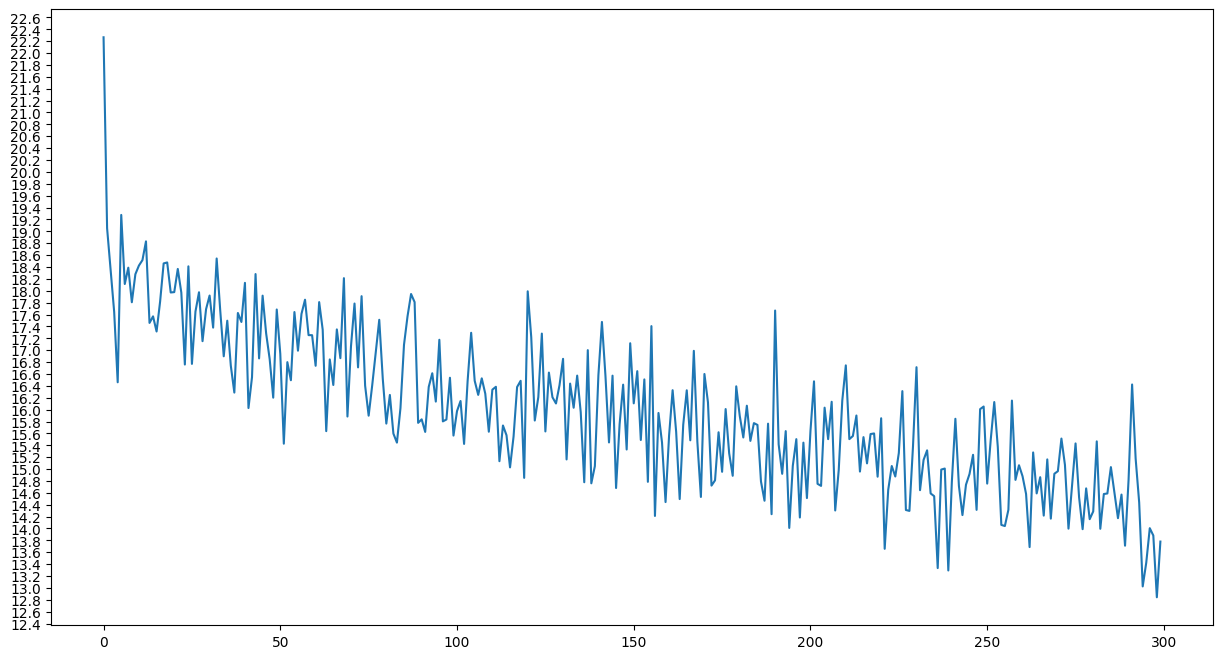

In [180]:
for iter in range(1,30001):

    training_pair = training_pairs[iter-1]
    input_tensor = training_pair[0]
    target_tensor = training_pair[1]

    loss = train (input_tensor,target_tensor,
                  encoder1,decoder1,
                  encoder_optimizer,decoder_optimizer,
                  criterion)
    
    print_loss_total+=loss

    plot_loss_total+=loss

    if iter % 1000 ==0:
        print_loss_avg = print_loss_total /100
        print_loss_total =0

        print ('iteration -%d loss - %.4f' % (iter,print_loss_avg))
    
    if iter % 100 ==0:
        print_loss_avg =plot_loss_total /100

        plot_losses.append(print_loss_avg)
        plot_loss_total=0

fig,ax = plt.subplots(figsize=(15,8))

loc = ticker.MultipleLocator(base=0.2)

ax.yaxis.set_major_locator(loc)

plt.plot(plot_losses)



In [181]:
def evaluate(encoder,decoder,sentence):

    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang,sentence)
        input_length = input_tensor.size(0)

        encoder_hidden = encoder.initHidden()

        for ei in range(input_length):
            encoder_output , encoder_hidden = encoder(input_tensor[ei],
                                                      encoder_hidden)
            
        decoder_input = torch.tensor([[SOS_token]])

        decoder_hidden = encoder_hidden

        decoded_words =[]

        for di in range(MAX_LENGTH):

            decoder_output , decoder_hidden = decoder(decoder_input,
                                                      decoder_hidden)
            
            decoder_input = torch.tensor([[SOS_token]])

            topv, topi = decoder_output.data.topk(1)

            if topi.item()==EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                  decoded_words.append(output_lang.index2word[topi.item()])
            
            decoder_input = topi.squeeze().detach()

        return decoded_words



In [182]:
for i in range (10):

    pair = random.choice(pairs)

    print ('>',pair[0])
    print ('=',pair[1])

    output_words = evaluate(encoder1,decoder1,pair[0])

    output_sentence = ' '.join(output_words)

    print ('<',output_sentence)

    print ('')

    

> i m good at swimming
= ich bin ein guter schwimmer
< ich bin mit dem dem <EOS>

> i have an older brother and a younger sister
= ich habe einen alteren bruder und eine jungere schwester
< ich habe einen und schwester schwester schwester schwester schwester schwester

> i did nothing
= ich habe nichts getan
< ich habe nichts getan <EOS>

> i haven t seen them since last month
= ich habe sie seit letztem monat nicht gesehen
< ich habe sie gestern nicht gesehen gesehen gesehen gesehen gesehen

> we hardly realize how important it is
= wir sind uns kaum bewusst wie wichtig es ist
< wir sind noch wie er <EOS>

> i asked questions
= ich habe fragen gestellt
< ich habe fragen fragen fragen <EOS>

> i ve been thinking about tom s plan
= ich habe uber toms plan nachgedacht
< ich bin toms nachgedacht nachgedacht nachgedacht <EOS>

> i just spoke with tom
= ich habe gerade mit tom gesprochen
< ich habe gerade mit tom gesprochen gesprochen <EOS>

> you really are strong
= du bist wirklich stark


In [195]:
input_sentence = 'i have a head ache'

In [196]:
output_words = evaluate(encoder1,
                        decoder1,
                        input_sentence)

KeyError: 'ache'

In [194]:
print ('input =',input_sentence)
print ('output =',' '.join(output_words))

input = i m good at eating
output = ich bin gut dem in <EOS>
